In [64]:
from __future__ import division
from astropy.io import fits
import os
import glob
import copy
import numpy as np
from astropy.table import Table, Column
import astropy.wcs as wcs
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.utils.data import get_pkg_data_filename
from astropy.io import ascii
from scipy.optimize import curve_fit
import sys


import sep
import matplotlib.pyplot as plt
import copy

sep.set_extract_pixstack(30000000)
from IPython.display import clear_output


from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [33]:
# define path
path = 'Documents/136P1'

In [34]:
cd

/Users/runquanguan


In [35]:
os.chdir(path)
filename = glob.glob('*')

In [36]:
def get_bias(folder):
    Bias = []
    ARY = []
    # pick out bias frame
    for file in folder:
        data = fits.open(file)
        TYPE = data[0].header['IMAGETYP']
        if TYPE == 'Bias Frame':
            Bias.append(file)
            
    # extract data array from data 
    for file in Bias:
        data = fits.open(file)
        array = data[0].data
        # form arrays as a list
        ARY.append(array)
    # turn list into array again to sum up
    ARY = np.array(ARY)
    # sum up
    SUM = ARY.sum(axis=0)
    # average out
    AVG = SUM/len(ARY)
    # return result
    return AVG
   

In [37]:
def deal_science(folder):
    
    # build new lists
    science_frame = []
    dark_frame = []
    final_frame = []
    
    # define bias frame
    bias_frame = get_bias(folder)
    
    # clasify science frames and dark frames
    for file in folder:
        data = fits.open(file)
        
    # declare variables
        EXPTIME = data[0].header['EXPTIME']
        TYPE = data[0].header['IMAGETYP']
        DATA = data[0].data
        
    # classification
        if TYPE == 'Dark Frame':
            # remove bias for Dark frame
            DATA = DATA - bias_frame
            dark_frame.append(file)
        elif TYPE == 'Light Frame':
            # remove bias for Science frame
            DATA = DATA - bias_frame
            science_frame.append(file)
        else:
            pass
    
    # matching exposure time    
    for file_s in science_frame:
        
        data_s = fits.open(file_s)
        EXPTIME_s = data_s[0].header['EXPTIME']
        
        # for each science: match a dark by EXPST
        for file_d in dark_frame:
            
            data_d = fits.open(file_d)
            EXPTIME_d = data_d[0].header['EXPTIME']
            
            if EXPTIME_s == EXPTIME_d:
                data_s[0].data = data_s[0].data - data_d[0].data
                final_frame.append(file_s)
            else:
                pass

    return final_frame
            
        
            

In [38]:
filename = deal_science(filename)


JBE = EarthLocation(lat=37.005*u.deg, lon=-122.0631*u.deg, height=249*u.m)
utcoffset = -8*u.hour  # Eastern Daylight Time

time_set = []
exptime = []
ppixel = []
ppixel_sec = []


for name in filename:
    file = fits.open(name)
    
    hh = int(file[0].header['DATE-OBS'][11:][:2])
    mm = int(file[0].header['DATE-OBS'][11:][3:5])
    ss = int(file[0].header['DATE-OBS'][11:][6:8])
    time_set.append(hh + mm/60 + ss/3600)
    time_format = str(file[0].header['DATE-OBS'][:10])+" "+str(hh)+':'+str(mm)+':'+str(ss)
    obst = Time(time_format)-utcoffset
    frame = AltAz(obstime=obst,location=JBE)
    
    
    exptime.append(file[0].header['EXPTIME'])
    
    ppixel.append(np.average(file[0].data))
    ppixel_sec.append(np.average(file[0].data)/file[0].header['EXPTIME'])
    
    

   
    

In [39]:
timeset = Column(name='time', data=np.array(time_set), dtype=np.float64)
exptime = Column(name='exptime', data=np.array(exptime))
filename = Column(name='filename', data=filename)
ppixel = Column(name='ppixel', data=ppixel)
ppixel_sec = Column(name='ppixel_sec', data=ppixel_sec)

catalog = Table([filename, timeset ,exptime, ppixel,ppixel_sec])

In [40]:
catalog.sort('filename')
catalog

filename,time,exptime,ppixel,ppixel_sec
str24,float64,float64,float64,float64
ASTR136_COS.00000034.FIT,12.1975,60.0,131.85851595540177,2.1976419325900296
ASTR136_COS.00000035.FIT,12.22861111111111,60.0,127.20480328078943,2.120080054679824
ASTR136_COS.00000036.FIT,12.246388888888887,60.0,125.20367550941945,2.086727925156991
ASTR136_COS.00000037.FIT,12.264444444444445,60.0,130.0582186338588,2.1676369772309796
ASTR136_COS.00000038.FIT,12.297222222222222,50.0,125.90258874791746,2.5180517749583493
ASTR136_COS.00000039.FIT,12.312222222222223,50.0,125.14066128412149,2.50281322568243
ASTR136_COS.00000040.FIT,12.3275,50.0,123.63793669101628,2.4727587338203256
ASTR136_COS.00000041.FIT,12.346666666666668,50.0,126.39727797001153,2.5279455594002305
ASTR136_COS.00000042.FIT,12.361666666666666,50.0,125.32059720620275,2.506411944124055


In [117]:
x = catalog['time']
y = catalog['ppixel_sec']

fit = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
fit

xx = np.linspace(12.19,12.54)
yy = np.exp(fit[1]) * np.exp(fit[0] * xx)


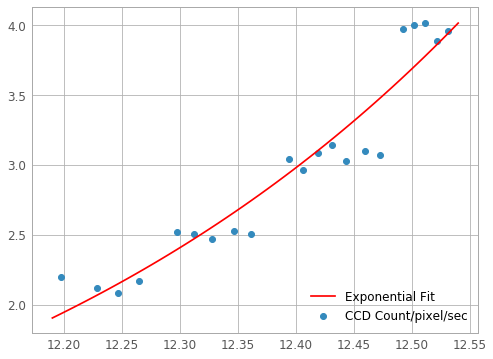

In [129]:
# plotting

plt.scatter(catalog['time'],catalog['ppixel_sec'],label='CCD Count/pixel/sec')
plt.plot(xx,yy,c='r',label='Exponential Fit')
plt.legend(loc=4, frameon=False)

## Test space

In [31]:
example = fits.open('ASTR136_COS.00000033.FIT')

image_file = get_pkg_data_filename('ASTR136_COS.00000033.FIT')

ex_header = example[0].header

data = example[0].data

data

array([[130, 124, 131, ..., 107, 107, 102],
       [139, 131, 128, ..., 113, 117, 110],
       [139, 135, 121, ..., 118, 115, 121],
       ...,
       [126, 142, 131, ..., 121, 111, 120],
       [135, 140, 142, ..., 121, 129, 119],
       [142, 145, 137, ..., 118, 114, 111]], dtype=uint16)